# Hierarchical Bayesian Neural Networks with Informative Priors

(c) 2018 by Thomas Wiecki

Imagine you have a machine learning (ML) problem but only small data (*gasp*, yes, this does exist). This often happens when your data set is nested -- you might have many data points, but only few per category / group. For example, in ad-tech you may want predict how likely a user will buy a certain product. There could be thousands of products but you only have a small number of measurements (e.g. purchase decisions) per item. Products are often part of a hierarchy where products can belong to different categories and share similarities with other products in the same category.

Using classic ML methods is unlikely to yield good results in this setting. Firstly, ML is happiest with lots of data. If you want to be fancy and use deep learning, that usually requires even more data to give good performance. Moreover, we can't really make use of the hierarchical structure (product-groupings) we know to be present in our data. So we can then either ignore it and try to learn one model for all categories which does not allow us to capture the differences between categories; or we can fit a ML model to each category separately but do not exploit the similarities between categories.

Hierarchical Bayesian models work amazingly well in exactly this setting as they allow us to build a model that matches the hierarchical structure present in our data set. Check out my [previous blog post](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/) for a refresher.

In this setting we could likely build a hierarchical logistic Bayesian model using PyMC3. However, what if our decision surface is actually more complex and a linear model does not give good performance?

In this blog post I explore how we can take a Bayesian Neural Network (BNN) and turn it into a hierarchical one. Once we built this model we derive an informed prior from it that we can apply back to a simple, non-hierarchical BNN to get the same performance as the hierachical one.

In [ ]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons
from pymc3 import floatX
import theano.tensor as tt

from pymc3.theanof import set_tt_rng, MRG_RandomStreams

filterwarnings('ignore')
sns.set_style('white')

set_tt_rng(MRG_RandomStreams(42))

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

layer_names = ['w_in_1_grp', 'w_1_2_grp', 'w_2_out_grp']

The data set we are using will again be the half-moons as it is simple, non-linear and leads to pretty visualizations. This is what it looks like:

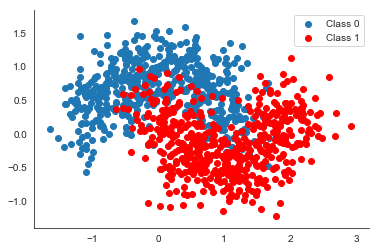

In [2]:
X, Y = make_moons(noise=0.3, n_samples=1000)
plt.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); plt.legend();

This is just to show you what the data looks like, we will be using way fewer data points, and create different subsets with different rotations.

In [3]:
def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X = X.dot(R)
    
    return np.asarray(X)

In [63]:
np.random.seed(31)

n_samples = 100
n_grps = 18
n_grps_sq = int(np.sqrt(n_grps))
Xs, Ys = [], []
for i in range(n_grps):
    # Generate data with 2 classes that are not linearly separable
    X, Y = make_moons(noise=0.3, n_samples=n_samples)
    X = scale(X)
    X = floatX(X)
    Y = floatX(Y)
    
    # Rotate the points randomly for each group
    rotate_by = np.random.randn() * 90.
    X = rotate(X, rotate_by)
    Xs.append(X)
    Ys.append(Y)
    
Xs = np.stack(Xs)
Ys = np.stack(Ys)

Xs_train = Xs[:, :n_samples // 2, :]
Xs_test = Xs[:, n_samples // 2:, :]
Ys_train = Ys[:, :n_samples // 2]
Ys_test = Ys[:, n_samples // 2:]

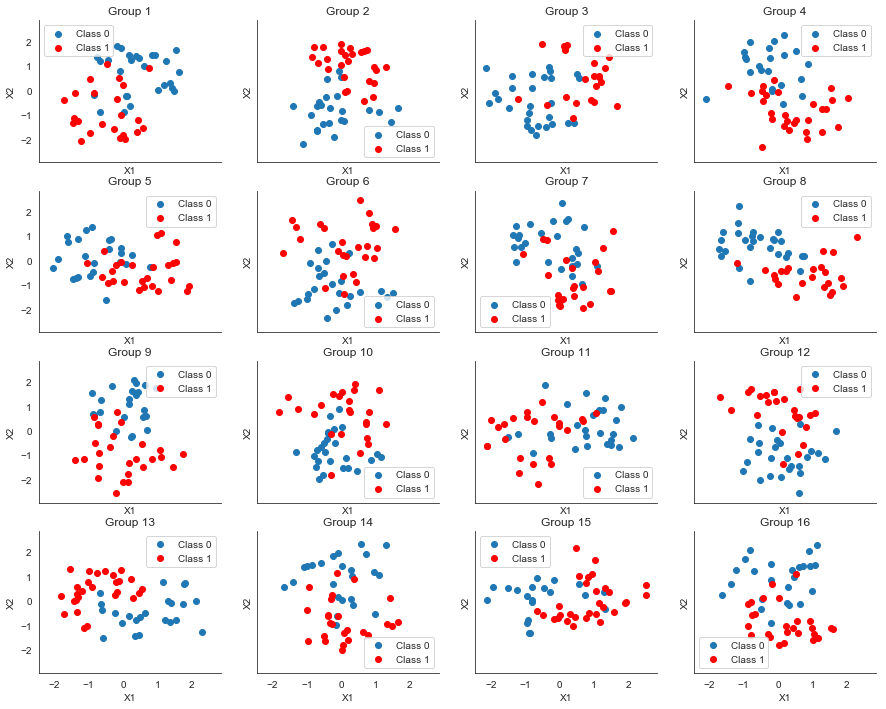

In [5]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, 
                        sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y, ax) in enumerate(zip(Xs_train, Ys_train, axs)):
    ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
    ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()
    ax.set(title='Group {}'.format(i + 1), xlabel='X1', ylabel='X2')

In [93]:
np.random.seed(31)

n_samples = 100
n_grps = 18
n_grps_sq = int(np.sqrt(n_grps))
Xs, Ys = [], []
for i in range(n_grps):
    # Generate data with 2 classes that are not linearly separable
    x, Y = make_moons(noise=0.3, n_samples=n_samples)
    x = scale(x)
    x = floatX(x)
    Y = floatX(Y)
    
    # Rotate the points randomly for each group
    rotate_by = np.random.randn() * 90.
    x = rotate(x, rotate_by)
    X = np.full((x.shape[0], x.shape[1] + 1), i / n_grps)
    X[:,:-1] = x
    Xs.append(X)
    Ys.append(Y)
    
Xs = np.vstack(Xs)
Ys = np.concatenate(Ys)
n_samples *= n_grps

Xs_train = Xs[:n_samples // 2, :]
Xs_test = Xs[n_samples // 2:, :]
Ys_train = Ys[:n_samples // 2]
Ys_test = Ys[n_samples // 2:]

As you can see, we have 18 groups that share a higher-order structure. However, in the pure data space, no single classifier will be able to do a good job here. Also, because we only have 50 data points in each class, a NN will likely have a hard time producing robust results. But let's actually test this.

## Classify each group separately

The code for the NN below is explained in [this blog post](https://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/).

In [72]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = floatX(np.random.randn(X.shape[1], n_hidden))
    init_2 = floatX(np.random.randn(n_hidden, n_hidden))
    init_out = floatX(np.random.randn(n_hidden))
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.dot(act_2, weights_2_out)
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           logit_p=act_out,
                           observed=ann_output)
    return neural_network

Next, we loop over each group and fit a different BNN to each one. We use NUTS sampling here because the hierarchical model further below has a more complex posterior (see [Why hierarchical models are awesome, tricky, and Bayesian](https://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/) for an explanation) and I wanted the results to be comparable. All simulations in here work with ADVI as well but the results don't look quite as strong.

In [94]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = floatX(np.random.randn(Xs_train.shape[1], n_hidden))
    init_2 = floatX(np.random.randn(n_hidden, n_hidden))
    init_out = floatX(np.random.randn(n_hidden))
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(Xs_train.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.dot(act_2, weights_2_out)
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           logit_p=act_out,
                           observed=ann_output)
    return neural_network

ann_input = theano.shared(Xs_train)
ann_output = theano.shared(Ys_train)
neural_network = construct_nn(ann_input, ann_output)
    
with neural_network:
    trace = pm.sample(init='advi+adapt_diag') # fit model
    ppc_train = pm.sample_ppc(trace, samples=500, progressbar=False) # sample posterior predictive

    # Use probability of > 0.5 to assume prediction of class 1
    pred_train = ppc_train['out'].mean(axis=0) > 0.5
    Ys_pred_train.append(pred_train)

    # Make predictions on test-set
    ann_input.set_value(Xs_test)
    ann_output.set_value(Ys_test)
    ppc_test = pm.sample_ppc(trace, samples=500, progressbar=False)

    pred_test = ppc_test['out'].mean(axis=0) > 0.5
    Ys_pred_test = pred_test

    # Evaluate classifier over grid
    ann_input.set_value(grid_2d)
    ann_output.set_value(dummy_out)
    ppc_grid = pm.sample_ppc(trace, samples=500, progressbar=False)
    grid_eval = ppc_grid['out']

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 639.62:   8%|▊         | 16355/200000 [00:22<04:13, 724.52it/s]
Convergence achieved at 16400
Interrupted at 16,399 [8%]: Average Loss = 697.46
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_2_out, w_1_2, w_in_1]
Sampling 2 chains: 100%|██████████| 2000/2000 [01:59<00:00, 16.74draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


ValueError: shapes (10000,2) and (3,5) not aligned: 2 (dim 1) != 3 (dim 0)
Apply node that caused the error: dot(<TensorType(float64, matrix)>, w_in_1)
Toposort index: 0
Inputs types: [TensorType(float64, matrix), TensorType(float32, matrix)]
Inputs shapes: [(10000, 2), (3, 5)]
Inputs strides: [(8, 80000), (20, 4)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Elemwise{Tanh}[(0, 0)](dot.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/twiecki/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/twiecki/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/twiecki/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/twiecki/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/twiecki/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/twiecki/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-94-22a11a42d56c>", line 38, in <module>
    neural_network = construct_nn(ann_input, ann_output)
  File "<ipython-input-94-22a11a42d56c>", line 26, in construct_nn
    act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [95]:
(pred_train == Ys_train).mean()

0.6455555555555555

In [ ]:
Ys_pred_train = []
Ys_pred_test = []
grid_eval = []

grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

for X_train, Y_train, X_test, Y_test in zip(Xs_train, Ys_train, Xs_test, Ys_test):
    ann_input = theano.shared(X_train)
    ann_output = theano.shared(Y_train)
    neural_network = construct_nn(ann_input, ann_output)
    
    with neural_network:
        trace = pm.sample(init='advi+adapt_diag') # fit model
        ppc_train = pm.sample_ppc(trace, samples=500, progressbar=False) # sample posterior predictive
        
        # Use probability of > 0.5 to assume prediction of class 1
        pred_train = ppc_train['out'].mean(axis=0) > 0.5
        Ys_pred_train.append(pred_train)
        
        # Make predictions on test-set
        ann_input.set_value(X_test)
        ann_output.set_value(Y_test)
        ppc_test = pm.sample_ppc(trace, samples=500, progressbar=False)

        pred_test = ppc_test['out'].mean(axis=0) > 0.5
        Ys_pred_test.append(pred_test)
        
        # Evaluate classifier over grid
        ann_input.set_value(grid_2d)
        ann_output.set_value(dummy_out)
        ppc_grid = pm.sample_ppc(trace, samples=500, progressbar=False)
        grid_eval.append(ppc_grid['out'])

Ys_pred_train = np.stack(Ys_pred_train)
Ys_pred_test = np.stack(Ys_pred_test)
ppc_grid_single = np.stack(grid_eval)

In [9]:
print ("Train accuracy = {:.2f}%".format(100*np.mean(Ys_pred_train == Ys_train)))

Train accuracy = 85.00%


In [10]:
print ("Test accuracy = {:.2f}%".format(100*np.mean(Ys_pred_test == Ys_test)))

Test accuracy = 85.33%


OK, that doesn't seem so bad. Now let's look at the decision surfaces -- i.e. what the classifier thinks about each point in the data space.

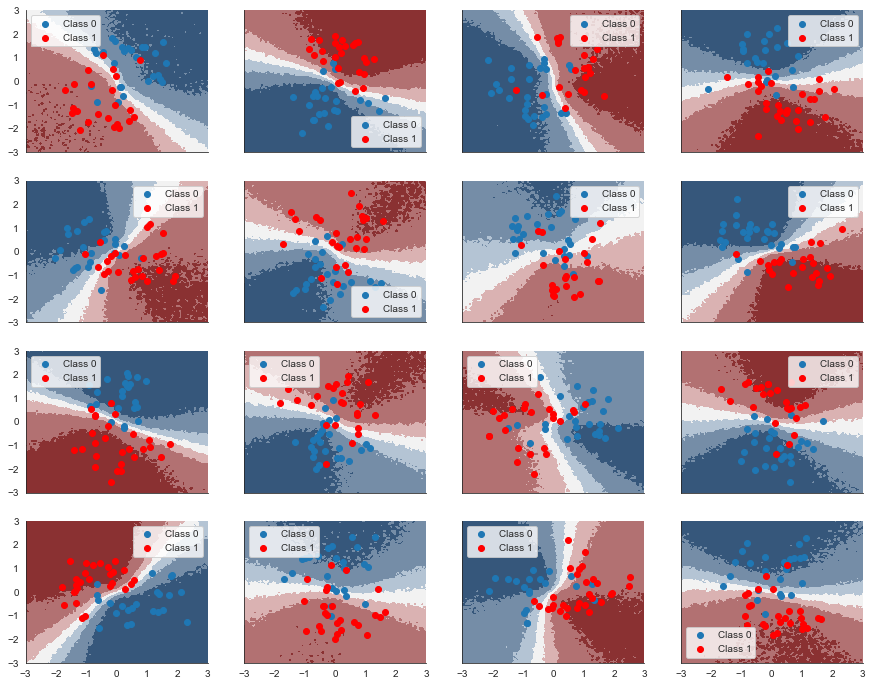

In [11]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[0], grid[1], ppc_grid_single[i, ...].mean(axis=0).reshape(100, 100), cmap=cmap)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()

That doens't look all that convincing. We know from the data generation process as well as from the previous blog posts using this process that it give us a "Z"-shaped decision surface. So what happens is we don't have enough data to properly estimate the non-linearity in every group.

## Hierarchical Bayesian Neural Network

Can we do better? You bet!

It's actually quite straight-forward to turn this into one big hierarchical model, rather than many individual ones. Let's call the weight connecting neuron $i$ in layer 1 to neuron $j$ in layer 2 $w_{i, j}$ (I just fixed the layers for simplicity in notation). Rather than placing a fixed prior as we did above (i.e. $ w_{i, j} \sim \mathcal{N}(0, 1^2)$), we will assume that each weight comes from an overarching group distribution:
$ w_{i, j} \sim \mathcal{N}(\mu_{i, j}, \sigma^2)$. The key is that we will estimate $\mu_{i, j}$ and $\sigma$ simultaneously from data. Why not allow for different $\sigma_{i,j}^2$ per connection? Mainly just to make our life simpler.

Note that we create a very rich model here. Every individual weight has its own hierarchical structure with a single group mean parameter and 16 per-group weights distributed around the group mean, while the group variability is shared per layer. While this creates a big amount of group distributions there is no problem with this per-se, although it might be a bit unusual. One might argue that this model is quite complex and while that's true, in terms of degrees-of-freedom, this model simpler than the unpooled one above.

As for the code, we stack weights along a 3rd dimenson to get separate weights for each group. That way, through the power of broadcasting, the linear algebra works out almost the same as before.

In [12]:
def construct_hierarchical_nn(Xs, Ys):
    n_hidden = 5
    n_grps = Xs.shape[0].eval()
    n_data = Xs.shape[2].eval()
    # Initialize random weights between each layer
    init_1 = floatX(np.random.randn(n_data, n_hidden))
    init_2 = floatX(np.random.randn(n_hidden, n_hidden))
    init_out = floatX(np.random.randn(n_hidden))
        
    with pm.Model() as neural_network:
        # Group mean distribution for input to hidden layer
        weights_in_1_grp = pm.Normal('w_in_1_grp', 0, sd=1, 
                                 shape=(n_data, n_hidden), 
                                 testval=init_1)
        # Group standard-deviation
        weights_in_1_grp_sd = pm.HalfNormal('w_in_1_grp_sd', sd=1.)
        
        # Group mean distribution for weights from 1st to 2nd layer
        weights_1_2_grp = pm.Normal('w_1_2_grp', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        weights_1_2_grp_sd = pm.HalfNormal('w_1_2_grp_sd', sd=1.)
        
        # Group mean distribution from hidden layer to output
        weights_2_out_grp = pm.Normal('w_2_out_grp', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        weights_2_out_grp_sd = pm.HalfNormal('w_2_out_grp_sd', sd=1.)
    
        # Separate weights for each different model, just add a 3rd dimension
        # of weights
        weights_in_1_raw = pm.Normal('w_in_1', shape=(n_grps, n_data, n_hidden))
        # Non-centered specification of hierarchical model
        # see https://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/
        weights_in_1 = weights_in_1_raw * weights_in_1_grp_sd + weights_in_1_grp
        
        weights_1_2_raw = pm.Normal('w_1_2', shape=(n_grps, n_hidden, n_hidden))
        weights_1_2 = weights_1_2_raw * weights_1_2_grp_sd + weights_1_2_grp
        
        weights_2_out_raw = pm.Normal('w_2_out', shape=(n_grps, n_hidden))
        
        weights_2_out = weights_2_out_raw * weights_2_out_grp_sd + weights_2_out_grp
        
        # Build neural-network using tanh activation function
        # tt.batched_dot just calls .dot along an axis
        act_1 = pm.math.tanh(tt.batched_dot(Xs, weights_in_1))
        act_2 = pm.math.tanh(tt.batched_dot(act_1, weights_1_2))
        act_out = pm.Deterministic('act_out', tt.batched_dot(act_2, weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', logit_p=act_out, observed=Ys)
        
    return neural_network

In [ ]:
ann_input_hier = theano.shared(Xs_train)
ann_output_hier = theano.shared(Ys_train)

hierarchical_neural_network = construct_hierarchical_nn(ann_input_hier, ann_output_hier)

with hierarchical_neural_network:
    trace_nuts = pm.sample(init='advi+adapt_diag', tune=4000, chains=1)
    ppc_train = pm.sample_ppc(trace_nuts, samples=500, progressbar=False)

    # Use probability of > 0.5 to assume prediction of class 1
    Ys_hierarchical_pred_train = ppc_train['out'].mean(axis=0) > 0.5

    ann_input_hier.set_value(Xs_test)
    ann_output_hier.set_value(Ys_test)
    ppc_test = pm.sample_ppc(trace_nuts, samples=500, progressbar=False)

    # Use probability of > 0.5 to assume prediction of class 1
    Ys_hierarchical_pred_test = ppc_test['out'].mean(axis=0) > 0.5

In [14]:
print('Train accuracy = {:.2f}%'.format(100*np.mean(Ys_hierarchical_pred_train == Ys_train)))

Train accuracy = 90.56%


In [15]:
print('Test accuracy = {:.2f}%'.format(100*np.mean(Ys_hierarchical_pred_test == Ys_test)))

Test accuracy = 90.44%


Great -- we get higher train *and* test accuracy. Let's look at what the classifier has learned for each group.

In [20]:
grid_3d = np.repeat(grid_2d[None, ...], n_grps, axis=0)
dummy_out_3d = np.ones((n_grps, grid.shape[1]), dtype=np.int8)

ann_input_hier.set_value(grid_3d)
ann_output_hier.set_value(dummy_out_3d)

with hierarchical_neural_network:
    ppc_grid = pm.sample_ppc(trace_nuts, samples=500, progressbar=False)

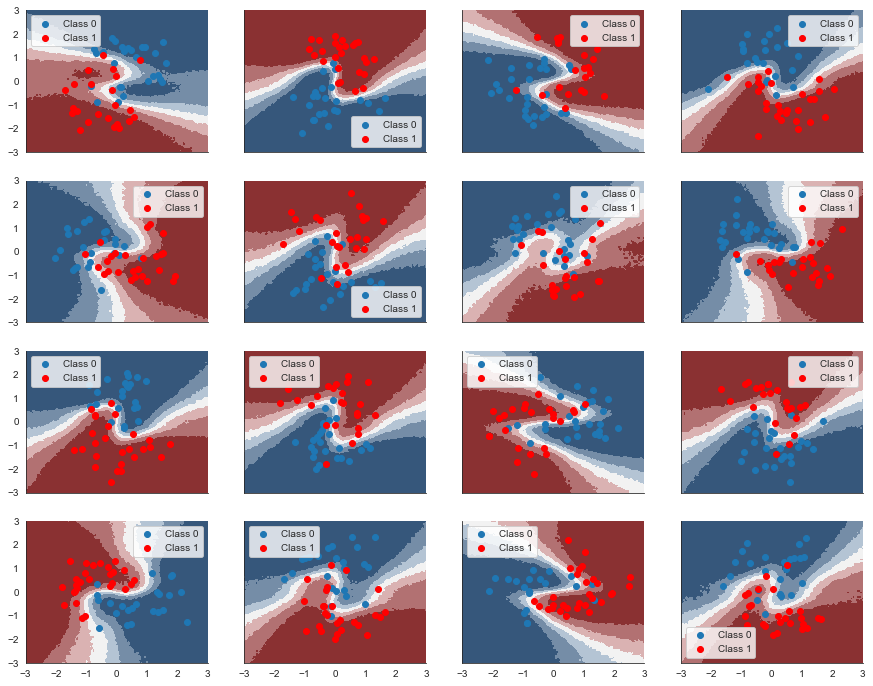

In [21]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_hierarchical_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[0], grid[1], ppc_grid['out'][:, i, :].mean(axis=0).reshape(100, 100), cmap=cmap)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()

Awesome! By (partially) pooling the data for each individual group we actually manage to retrieve the non-linearity. This is the strength of hierarchical models: we model the group-wise similarities *and* their differences, sharing statistical power to the degree it's useful.

Of course, as we are in a Bayesian framework we also get the uncertainty estimate in our predictions:

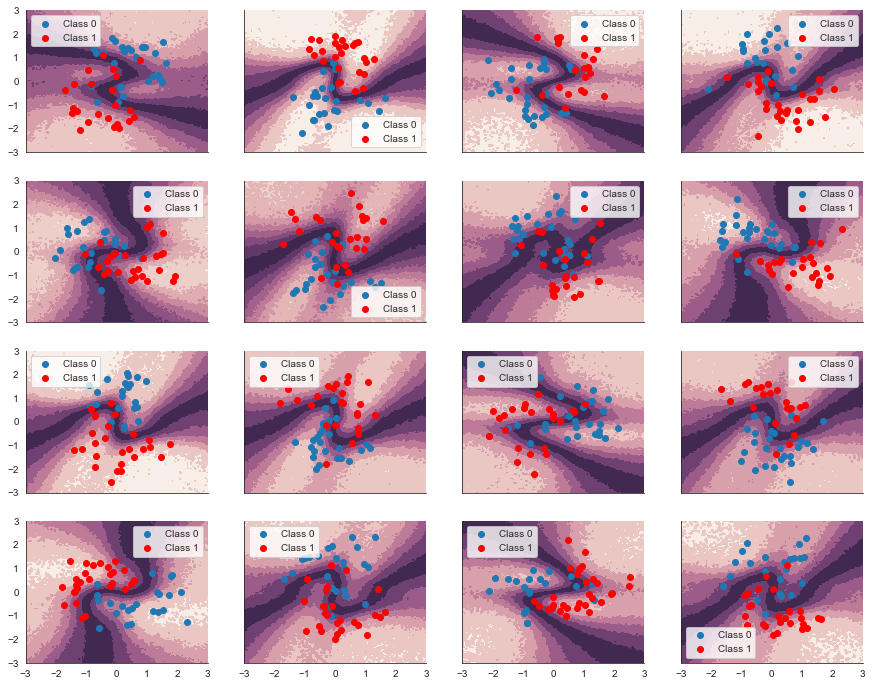

In [22]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_hierarchical_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[0], grid[1], ppc_grid['out'][:, i, :].std(axis=0).reshape(100, 100), 
                          cmap=cmap_uncertainty)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()

### Further analysis

There are a couple of things we might ask at this point. For example, how much does each layer specialize it's weight per group. To answer this we can look at the group standard-deviation which informs us how much each weight is allowed to deviate from its group mean.

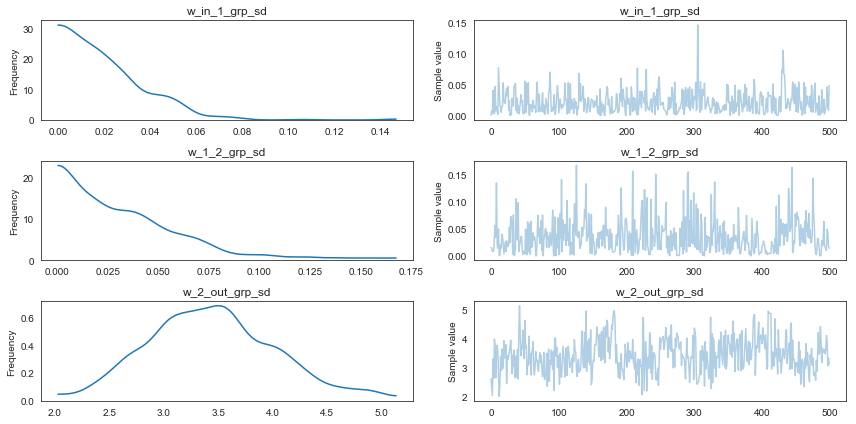

In [23]:
pm.traceplot(trace_nuts, varnames=['w_in_1_grp_sd', 'w_1_2_grp_sd', 'w_2_out_grp_sd']);

Interestingly, it seems that the specialization of the per-group-model is happening at the last layer where weights change most strongly from their group mean (as group variance is highest). I had assumed that this would happen at the first layer, based on what I found in this earlier blog post where the first layer acted as a rotation-layer.

Another interesting property of hierarchical models reveals itself here. As the group standard deviation is small for the weights in layers 1 and 2, it means these weights will be close to their group mean. This is very different from the separate model approach above. 

Finally, I wondered what the group-model actually learned. To get at that, we can use the trace of $\mu_{i,j}$ from the hierarchical model and pass it to the non-hierarchical model as if we trained these weights directly on a single data set. 

In [24]:
trace._straces[0].samples['w_in_1'] = trace_nuts['w_in_1_grp']
trace._straces[0].samples['w_1_2'] = trace_nuts['w_1_2_grp']
trace._straces[0].samples['w_2'] = trace_nuts['w_2_out_grp']

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

with neural_network:
    # Evaluate classifier over grid
    ann_input.set_value(grid_2d)
    ann_output.set_value(dummy_out)
    ppc_grid_hier2 = pm.sample_ppc(trace, samples=500, progressbar=False)['out']

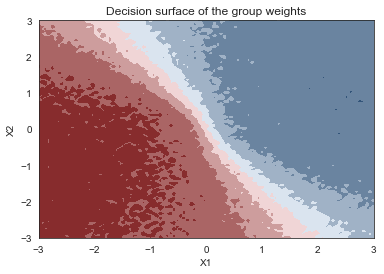

In [25]:
contour = plt.contourf(grid[0], grid[1], ppc_grid_hier2.mean(axis=0).reshape(100, 100), cmap=cmap)
plt.xlabel('X1'); plt.ylabel('X2'); plt.title('Decision surface of the group weights');

## Correlations between weights

Usually we estimate NNs with MLE and BNNs with mean-field variational inference which both ignore correlations between weights. As we used NUTS here, I was curious if there are meaningful correlations. Here we look at the correlations in individual layers of the group distribution.

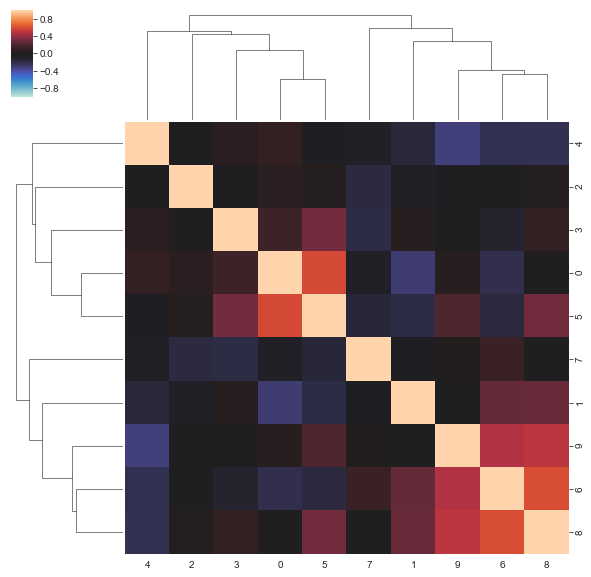

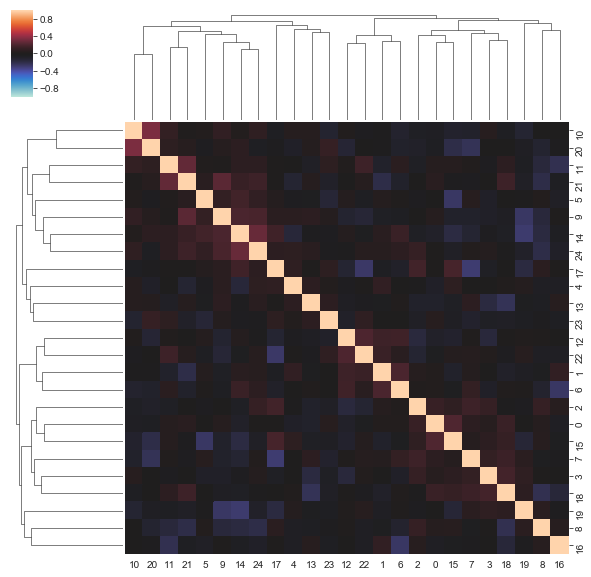

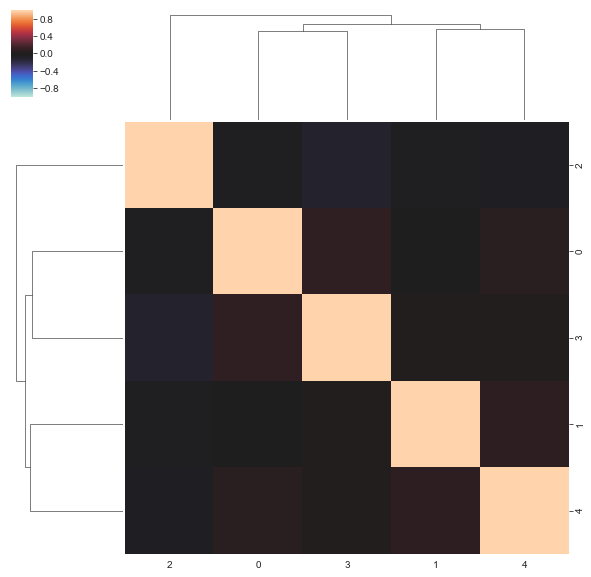

In [26]:
for layer_name in layer_names:
    sns.clustermap(np.corrcoef(trace_nuts[layer_name].reshape((trace_nuts[layer_name].shape[0], -1)).T), vmin=-1, center=0, vmax=1)

It indeed seems like point or mean-field estimates miss a lot of high-order structure.

## Informative priors for Bayesian Neural Networks

Informative priors are a powerful concept in Bayesian modeling. Any expert information you encode in your priors can greatly increase your inference.

The same should hold true for BNNs but it raises the question how we can define informative priors over weights which exist in this abstract space that is very difficult to reason about (understanding the learned representations of neural networks is an active research topic).

While I don't know to answer that generally, we can nonetheless explore this question with the techniques we developed this far. The group distributions from our hierarchical model are providing structured regularization for the subnetworks. But there is no reason we can't use the group distributions only in a hierarchical network. We can just use the inferred group structure and reapply it in the form on informative priors to individual networks.

For this, we must first estimate the group distribution. The easiest approach is to just draw samples from the group posterior distributions and, using these samples, draw realizations from the distribution as it would look to the subnetworks. This is essentially sampling from the posterior predictive distribution for new groups.

In [27]:
from collections import defaultdict
samples_tmp = defaultdict(list)
samples = {}

for layer_name in layer_names:
    for mu, sd in zip(trace_nuts.get_values(layer_name, chains=0),
                      trace_nuts.get_values(layer_name+'_sd', chains=0)):
        for _ in range(20): # not sure why the `size` kwarg didn't work
            samples_tmp[layer_name].append(stats.norm(mu, sd).rvs())
    samples[layer_name] = np.asarray(samples_tmp[layer_name])

While there is no guarantee that this distribution is normal (technically it is a mixture of normals so could look much more like a Student-T), this is a good enough approximation in this case. As the correlation structure of the group distributions seem to play a key role, we use MvNormal priors.

Note that this code just creates a single, non-hierarchical BNN.

In [28]:
def construct_nn_prior(ann_input, ann_output, prior_1_mu, prior_1_cov, prior_2_mu, prior_2_cov, prior_out_mu, prior_out_cov):
    n_hidden = 5
          
    with pm.Model() as neural_network:
        # In order to model the correlation structure between the 2D weights,
        # we flatten them first. Now here we have to reshape to give them their
        # original 2D shape.
        weights_in_1 = pm.MvNormal('w_in_1', prior_1_mu.flatten(), 
                                   cov=prior_1_cov, 
                                   shape=prior_1_cov.shape[0]).reshape((X.shape[1], n_hidden))
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.MvNormal('w_1_2', prior_2_mu.flatten(), 
                                  cov=prior_2_cov, 
                                  shape=prior_2_cov.shape[0]).reshape((n_hidden, n_hidden))
        
        # Weights from hidden layer to output
        weights_2_out = pm.MvNormal('w_2_out', prior_out_mu.flatten(), 
                                    cov=prior_out_cov, 
                                    shape=prior_out_cov.shape[0]).reshape((n_hidden,))
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.dot(act_2, weights_2_out)
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           logit_p=act_out,
                           observed=ann_output)
    return neural_network

Again, we just loop over the groups in our data set and create a separate BNN for each one. This is identical to our first attempt above, however, now we are using the group prior estimated by our hierarchical model in our second approach. 

In [ ]:
Ys_pred_train = []
Ys_pred_test = []
grid_eval = []

grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

for X_train, Y_train, X_test, Y_test in zip(Xs_train, Ys_train, Xs_test, Ys_test):
    ann_input = theano.shared(X_train)
    ann_output = theano.shared(Y_train)
    n_samples = samples['w_in_1_grp'].shape[0]
    neural_network = construct_nn_prior(ann_input, 
                                        ann_output, 
                                        samples['w_in_1_grp'].mean(axis=0),
                                        np.cov(samples['w_in_1_grp'].reshape((n_samples, -1)).T),
                                        samples['w_1_2_grp'].mean(axis=0),
                                        np.cov(samples['w_1_2_grp'].reshape((n_samples, -1)).T),
                                        samples['w_2_out_grp'].mean(axis=0),
                                        np.cov(samples['w_2_out_grp'].reshape((n_samples, -1)).T),
                                        )
    
    with neural_network:
        trace = pm.sample()
        ppc_train = pm.sample_ppc(trace, samples=500, progressbar=False)
        
        # Use probability of > 0.5 to assume prediction of class 1
        pred_train = ppc_train['out'].mean(axis=0) > 0.5
        Ys_pred_train.append(pred_train)
        
        # Make predictions on test-set
        ann_input.set_value(X_test)
        ann_output.set_value(Y_test)
        ppc_test = pm.sample_ppc(trace, samples=500, progressbar=False)

        pred_test = ppc_test['out'].mean(axis=0) > 0.5
        Ys_pred_test.append(pred_test)
        
        # Evaluate classifier over grid
        ann_input.set_value(grid_2d)
        ann_output.set_value(dummy_out)
        ppc_grid = pm.sample_ppc(trace, samples=500, progressbar=False)
        grid_eval.append(ppc_grid['out'])

grid_eval = np.asarray(grid_eval)

**Drum roll**

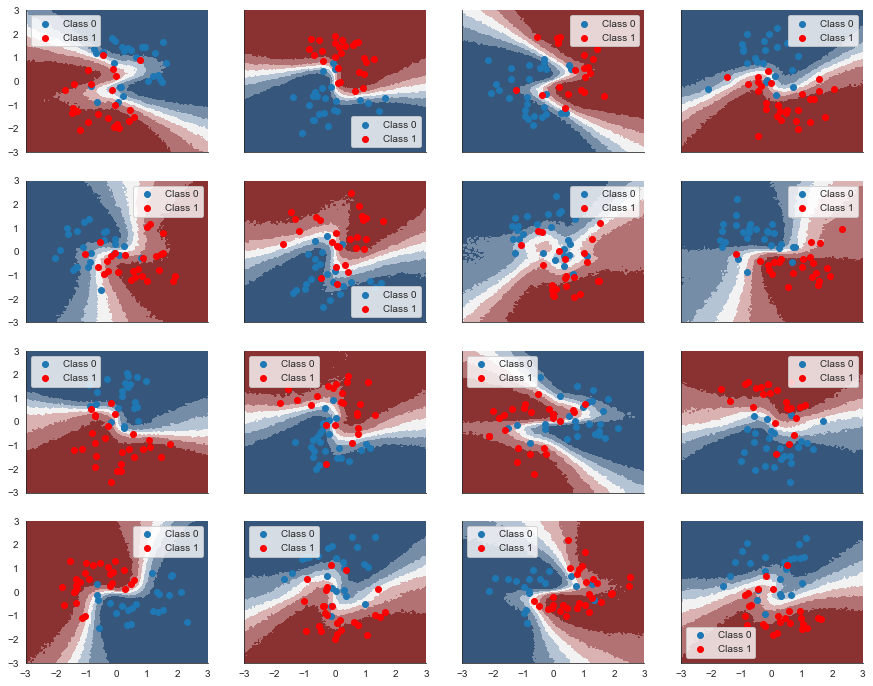

In [30]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[0], grid[1], grid_eval[i, ...].mean(axis=0).reshape(100, 100), cmap=cmap)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()

In [31]:
print('Train accuracy = {:.2f}%'.format(100*np.mean(Ys_hierarchical_pred_train == Ys_train)))

Train accuracy = 90.56%


In [32]:
print('Test accuracy = {:.2f}%'.format(100*np.mean(Ys_hierarchical_pred_test == Ys_test)))

Test accuracy = 90.44%


It actually worked!

Here, we show that informed priors can help NNs a lot. But what if we don't have hierarchical structure or it would be too expensive to estimate? We could attempt to construct priors by deriving them from pre-trained models. For example, if I wanted to train an object recognition model to my own custom categories, I could start with a model like ResNet trained on the CIFAR data set, derive priors from the weights, and then train a new model on my custom data set which could then get by with fewer images than if we trained from scratch.

## Acknowledgements

If you enjoyed this blog post, please consider supporting me on [Patreon](https://www.patreon.com/twiecki).

Thanks to [Adrian Seyboldt](https://twitter.com/aseyboldt) for useful discussions and for spotting bugs. Thanks also to my patrons, particularily  [Jonathan Ng](https://twitter.com/_jonathanng_) and [Vladislavs Dovgalecs](https://twitter.com/dovgalec).